# Wobbles Analysis with Accelerometry 

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as si
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import neurokit2 as nk
from dtw import dtw, accelerated_dtw
import emd
import glob
import os

sns.set()

## Import Data 

In [2]:
file_list = glob.glob(os.path.join(os.getcwd(), '/Users/luissilva/PycharmProjects/PhysioOper/data', "*.txt"))
file_list = np.sort(file_list)
print(file_list)

data = []

for file_path in file_list:
    load = np.loadtxt(file_path)
    data.append(load)

info = []

for file_path in file_list:
    with open(file_path, 'r') as f:
        lines = f.readlines()
        info.append(lines[1][19:21])

['/Users/luissilva/PycharmProjects/PhysioOper/data/S02_REST_POS_2021-11-11_17-41-17.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_REST_PRE_2021-11-11_16-17-24.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task1_2021-11-05_15-52-46.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task2_2021-11-05_16-13-59.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task3_2021-11-05_16-37-44.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_REST_POS_2021-11-11_13-06-56.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_REST_PRE_2021-11-11_11-15-07.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK1_2021-11-11_12-19-12.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK2_2021-11-11_12-35-07.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK3_2021-11-11_12-55-04.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S04_REST_POS_2021-11-11_17-41-17.txt'
 '/Users/luissilva/PycharmProjects/Phys

## Prepare Data 

In [3]:
id_value = 200000

for ii in range(0, len(data)):
    if len(data[ii]) > 200000:
        data[ii] = data[ii][len(data[ii]) - 570000 - 20000: -20000, :]
    else:
        data[ii] = data[ii][-120000:, :]

acc_data = []

for ii in range(0, len(data)):
    if info[ii] == 'AD':
        acc = np.array([data[ii][:, 11], data[ii][:, 12], data[ii][:, 13]])
        acc_data.append(acc)
    elif info[ii] == 'DC':
        acc = np.array([data[ii][:, 2], data[ii][:, 3], data[ii][:, 4]])
        acc_data.append(acc)

## Load Calib File 

In [4]:
calib_name = 'Acc_calib_new.txt'
calib = np.loadtxt(calib_name)

calib = np.array([calib[:, 2], calib[:, 3], calib[:, 4]])

## Calibration 

In [5]:
def convertAcc(signal, calib):
    acc_sig = (signal - np.min(calib) / (np.max(calib) - np.min(calib))) * 2 - 1
    return acc_sig


## Conversion ##

acc_conv = acc_data.copy()

for ii in range(0, len(acc_data)):
    acc = acc_data[ii]
    for jj in range(0, len(acc)):
        acc_conv[ii][jj, :] = convertAcc(acc[jj, :], calib[jj, :])

## Baseline Shift Correction 

In [6]:
acc_det = acc_conv.copy()

for ii in range(0, len(acc_conv)):
    acc = acc_conv[ii]
    for jj in range(0, len(acc)):
        acc_det[ii][jj, :] = acc[jj, :] - np.mean(acc[jj, :])


## Filtering Data

In [7]:
wind = 101

acc_fil = acc_det.copy()

for ii in range(0, len(acc_det)):
    acc = acc_det[ii]
    for jj in range(0, len(acc)):
        acc_fil[ii][jj, :] = si.savgol_filter(acc[jj, :], wind, 1)


## Wobbles Quantification 

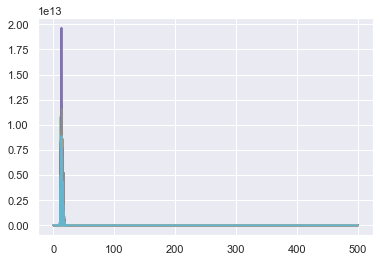

In [8]:
def power(data, fs, fig=1):
    ps = np.abs(np.fft.fft(data)) ** 2
    time = 1 / fs
    freqs = np.fft.fftfreq(data.size, time)
    idx = np.argsort(freqs)

    if fig == 1:
        plt.plot(np.abs(freqs[idx]), ps[idx])

    return freqs, ps, idx


## Filter data with a bandPass filter between 10 and 20 Hz ##

acc_1020 = acc_fil.copy()

for ii in range(0, len(acc_fil)):
    acc = acc_fil[ii]
    for jj in range(0, len(acc)):
        acc_1020[ii][jj, :] = nk.signal_filter(acc[jj, :], lowcut=10, highcut=20, method="butterworth", order=4)

subj = int(len(info) / 5)
acc_trap1020 = np.zeros((subj*5, 3))

for ii in range(0, len(acc_trap1020)):
    freqs_x, ps_x, idx_x = power(acc_1020[ii][0, :], 1000)
    freqs_y, ps_y, idx_y = power(acc_1020[ii][1, :], 1000)
    freqs_z, ps_z, idx_z = power(acc_1020[ii][2, :], 1000)

    acc_trap1020[ii, 0] = np.trapz(ps_x[idx_x], freqs_x[idx_x]) * 10e-12
    acc_trap1020[ii, 1] = np.trapz(ps_y[idx_y], freqs_y[idx_y]) * 10e-12
    acc_trap1020[ii, 2] = np.trapz(ps_z[idx_z], freqs_z[idx_z]) * 10e-12

## Wobbles Boxplot Among Conditions 

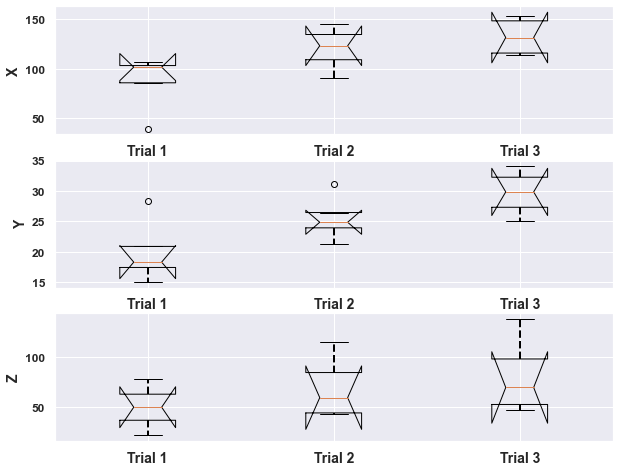

In [9]:
mom = [ii for ii in range(len(acc_fil)) if ii % 5 == 2]
plt.figure(figsize=[10, 8])

for ii in range(0, 3):
    c = acc_trap1020[:, ii]

    c1 = []
    c2 = []
    c3 = []

    for n in mom:
        t1 = c[n]
        c1.append(t1)
        t2 = c[n+1]
        c2.append(t2)
        t3 = c[n+2]
        c3.append(t3)

    plt.subplot(3, 1, ii + 1)

    labels = ['Trial 1', 'Trial 2', 'Trial 3']
    plt.boxplot([c1, c2, c3], notch=True, labels=labels, whiskerprops=dict(linestyle='--', linewidth=2.0))
    plt.xticks(fontweight='bold', fontsize=14)
    plt.yticks(fontweight='bold', fontsize=12)
    if ii == 0:
        plt.ylabel('X', fontweight='bold', fontsize=14)
    elif ii == 1:
        plt.ylabel('Y', fontweight='bold', fontsize=14)
    elif ii == 2:
        plt.ylabel('Z', fontweight='bold', fontsize=14)


<Figure size 720x576 with 0 Axes>

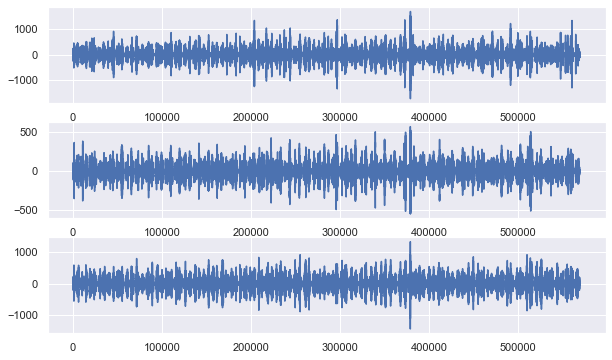

In [11]:
plt.figure(figsize=[10, 8])
def look_at_acc(x, y, z):
    plt.figure(figsize=[10,6])
    ax1 = plt.subplot(311)
    ax1.plot(x)
    ax2 = plt.subplot(312, sharex=ax1)
    ax2.plot(y)
    ax3 = plt.subplot(313, sharex=ax1)
    ax3.plot(z)
n = 3
look_at_acc(acc_data[n][0, :], acc_data[n][1, :], acc_data[n][2, :])